## ARCH and GARCH Models

https://github.com/bashtage/arch Package NB

In [3]:
! pip install arch


  Using cached arch-5.2.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (906 kB)
  Using cached property_cached-1.6.4-py2.py3-none-any.whl (7.8 kB)


In [17]:
import arch
from arch import arch_model
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import sys
from matplotlib.dates import DateFormatter
from scipy.stats import invweibull
from statsmodels.distributions.empirical_distribution import ECDF

sys.path.append("/home/jovyan/data_warehouse/")
from dw_src.api.features_api import get_features_df, load_features

### Prep Data

In [5]:
# High Frequency Data
features_to_load = [
    "midprice_mean",
    "traded_price_mean"

]

# Last 2 weeks
end_date = datetime.datetime.now(datetime.timezone.utc)
start_date = end_date - datetime.timedelta(days=7)

# Choose buckketing
time_agg = "30sec" # 1sec/5sec/10sec/30sec/60sec

high_freq= load_features(
    "ftx", "BTCUSDP", time_agg, start_date, end_date, features_to_load
)
high_freq.to_csv("1Min_BTCUSDP_March23_30.csv")

/opt/conda/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Query complete after 1.38s: 100%|██████████| 1/1 [00:01<00:00,  1.38s/query]
/opt/conda/lib/python3.8/site-packages/google/cloud/bigquery/client.py:444: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(
Downloading: 100%|██████████| 17016/17016 [00:00<00:00, 19676.67rows/s]


In [6]:
high_freq

,exchange,symbol,midprice_mean,traded_price_mean
timestamp,,,,
2022-03-29 02:12:00+00:00,ftx,BTCUSDP,47528.282991,47524.719101
2022-03-29 02:12:30+00:00,ftx,BTCUSDP,47517.212397,47516.571429
2022-03-29 02:13:00+00:00,ftx,BTCUSDP,47506.402019,47503.486486
2022-03-29 02:13:30+00:00,ftx,BTCUSDP,47493.702036,47493.840000
2022-03-29 02:14:00+00:00,ftx,BTCUSDP,47507.888807,47507.825000
...,...,...,...,...
2022-04-03 23:57:30+00:00,ftx,BTCUSDP,46440.500000,46440.727273
2022-04-03 23:58:00+00:00,ftx,BTCUSDP,46440.500000,46440.652174
2022-04-03 23:58:30+00:00,ftx,BTCUSDP,46418.550837,46413.879808


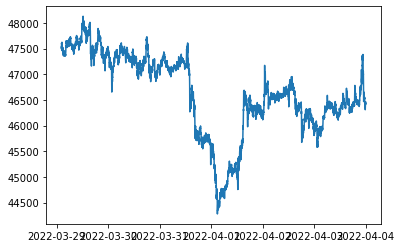

In [7]:
plt.plot(high_freq['midprice_mean'])

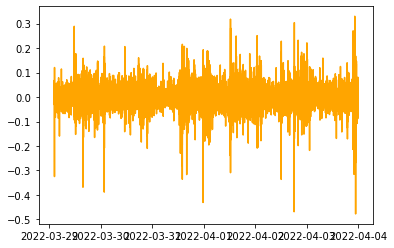

In [8]:
high_freq['return']=100 * high_freq['midprice_mean'].pct_change()
plt.plot(high_freq['return'].dropna(),color='orange')

In [9]:
high_freq

,exchange,symbol,midprice_mean,traded_price_mean,return
timestamp,,,,,
2022-03-29 02:12:00+00:00,ftx,BTCUSDP,47528.282991,47524.719101,NaN
2022-03-29 02:12:30+00:00,ftx,BTCUSDP,47517.212397,47516.571429,-0.023293
2022-03-29 02:13:00+00:00,ftx,BTCUSDP,47506.402019,47503.486486,-0.022750
2022-03-29 02:13:30+00:00,ftx,BTCUSDP,47493.702036,47493.840000,-0.026733
2022-03-29 02:14:00+00:00,ftx,BTCUSDP,47507.888807,47507.825000,0.029871
...,...,...,...,...,...
2022-04-03 23:57:30+00:00,ftx,BTCUSDP,46440.500000,46440.727273,-0.002466
2022-04-03 23:58:00+00:00,ftx,BTCUSDP,46440.500000,46440.652174,0.000000
2022-04-03 23:58:30+00:00,ftx,BTCUSDP,46418.550837,46413.879808,-0.047263


In [10]:
def generate_max(series): 
    '''
    Here is largest  loss for  last 5 minute returns (1 min increments) excluding nan values 
    
    '''
    max_values=np.array([])
    for i,x in enumerate(series.values):
        if np.isnan(series.values[i]):
            max_values=np.append(max_values,0)
            j=i
            continue
            
        max_values=np.append(max_values,min(series.values[max(j+1,i-9):i+1]))
 
    max_series=pd.Series(max_values,index=series.index)
    return -max_series # view losses as positive

In [11]:
high_freq['max_loss']=max_series=generate_max(high_freq['return'])

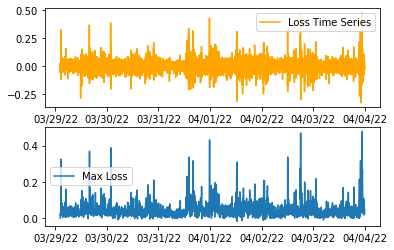

In [12]:
fig,ax = plt.subplots(2,1)


ax[1].plot(high_freq['max_loss'], label='Max Loss')
ax[0].plot(-high_freq['return'], label='Loss Time Series',color='orange') # flip returns to view
ax[0].legend()
ax[1].legend()
ax[0].xaxis.set_major_formatter(DateFormatter("%D"))
ax[1].xaxis.set_major_formatter(DateFormatter("%D"))

In [13]:
high_freq

,exchange,symbol,midprice_mean,traded_price_mean,return,max_loss
timestamp,,,,,,
2022-03-29 02:12:00+00:00,ftx,BTCUSDP,47528.282991,47524.719101,NaN,-0.000000
2022-03-29 02:12:30+00:00,ftx,BTCUSDP,47517.212397,47516.571429,-0.023293,0.023293
2022-03-29 02:13:00+00:00,ftx,BTCUSDP,47506.402019,47503.486486,-0.022750,0.023293
2022-03-29 02:13:30+00:00,ftx,BTCUSDP,47493.702036,47493.840000,-0.026733,0.026733
2022-03-29 02:14:00+00:00,ftx,BTCUSDP,47507.888807,47507.825000,0.029871,0.026733
...,...,...,...,...,...,...
2022-04-03 23:57:30+00:00,ftx,BTCUSDP,46440.500000,46440.727273,-0.002466,0.033172
2022-04-03 23:58:00+00:00,ftx,BTCUSDP,46440.500000,46440.652174,0.000000,0.033172
2022-04-03 23:58:30+00:00,ftx,BTCUSDP,46418.550837,46413.879808,-0.047263,0.047263


## Fitting a Frechet / Inverse Weibull Dist

In [32]:

shape,loc,scale=invweibull.fit(high_freq['max_loss'].values)
print(loc,scale,shape)

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


-0.08420093710731669 0.11709300776429453 5.1226420608039955


No handles with labels found to put in legend.


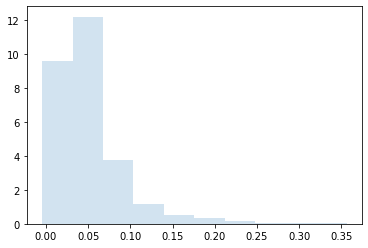

In [28]:
r = invweibull.rvs(shape,loc=loc,scale=scale, size=1000)
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2)
plt.legend(loc='best', frameon=False)
plt.show()

## Empirical Data

No handles with labels found to put in legend.


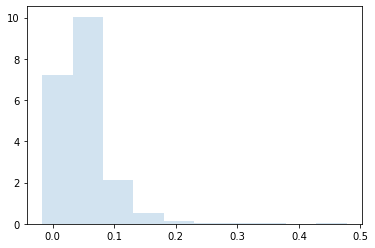

In [27]:
plt.hist(high_freq['max_loss'], density=True, histtype='stepfilled', alpha=0.2)
plt.legend(loc='best', frameon=False)
plt.show()

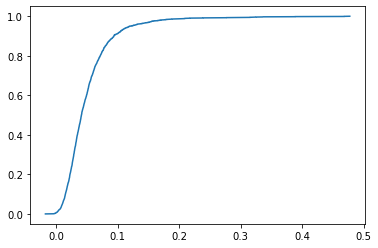

In [29]:
### Comparing Static distributions
ecdf=ECDF(high_freq['max_loss'])
plt.plot(ecdf.x,ecdf.y)



In [151]:
from arch.univariate import ARX # autoregressive model on max loss returns, 1 3, 12 lags

ar = ARX( 1000*high_freq['max_loss'], lags=1)
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:               max_loss   R-squared:                       0.869
Mean Model:                        AR   Adj. R-squared:                  0.869
Vol Model:          Constant Variance   Log-Likelihood:               -73762.9
Distribution:                  Normal   AIC:                           147532.
Method:            Maximum Likelihood   BIC:                           147555.
                                        No. Observations:                17933
Date:                Sat, Apr 02 2022   Df Residuals:                    17931
Time:                        18:36:57   Df Model:                            2
                                Mean Model                               
                  coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------------------------
Const           3.4193      0.367      9.306  1.333e-20 [  2.699,  

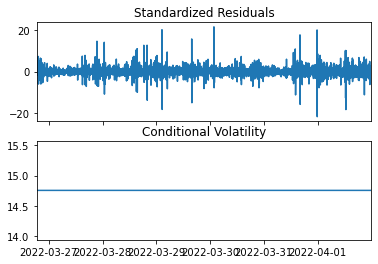

In [146]:
fig = ar.fit().plot()

In [147]:
from arch.univariate import GARCH
ar.volatility = GARCH()
res = ar.fit(update_freq=0, disp='off')
print(ar.fit().summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 2182809990.6179094
Iteration:      2,   Func. Count:     26,   Neg. LLF: 652011073.5563443
Iteration:      3,   Func. Count:     40,   Neg. LLF: 66356567.60528902
Iteration:      4,   Func. Count:     52,   Neg. LLF: 1738529.0857109618
Iteration:      5,   Func. Count:     62,   Neg. LLF: 119106.84265461483
Iteration:      6,   Func. Count:     72,   Neg. LLF: 76231.54004578211
Iteration:      7,   Func. Count:     83,   Neg. LLF: 72097.34540116308
Iteration:      8,   Func. Count:     92,   Neg. LLF: 92953.496173722
Iteration:      9,   Func. Count:    101,   Neg. LLF: 75401.52679994421
Iteration:     10,   Func. Count:    110,   Neg. LLF: 94516.16675098933
Iteration:     11,   Func. Count:    119,   Neg. LLF: 72080.37099708157
Iteration:     12,   Func. Count:    128,   Neg. LLF: 71946.67216121213
Iteration:     13,   Func. Count:    137,   Neg. LLF: 71835.17502648251
Iteration:     14,   Func. Count:    146,   Neg. LLF: 71769.998

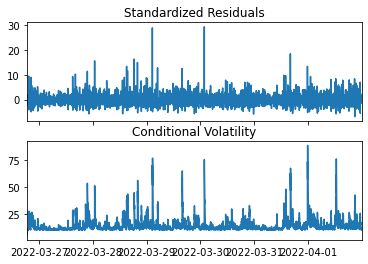

In [149]:
fig = res.plot()

### Relation to Paper

- We need time series models for both the shape and scale parameters, location is constant mean
- Univariate Autoregressive model
    - Need to get volatility Process and X Regressors process
    

In [ ]:
arch.univariate.ARX(y=None, x=None, lags=None, constant=True, hold_back=None, volatility=None, distribution=None, rescale=None)